In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Generate synthetic dataset with 3 classes

In [ ]:
n_samples = 1000
n_features = 10
n_classes = 3

X, y = make_classification(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=6, 
    n_redundant=2, 
    n_classes=n_classes, 
    n_clusters_per_class=1, 
    random_state=42
)

In [4]:
encoder = OneHotEncoder(sparse_output=False)  # Corrected argument
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train, test, validation split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Dataset visualizing with markers

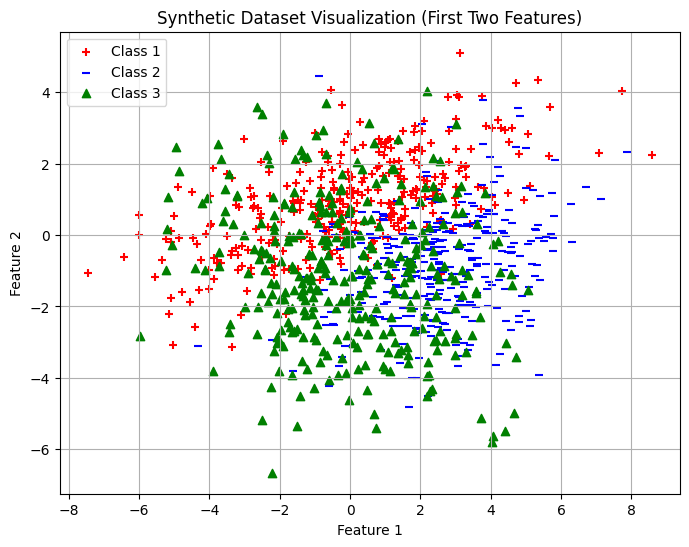

In [8]:
markers = ['+', '_', '^']  # "+" for Class 1, "_" (underscore) for Class 2, "^" (triangle) for Class 3
colors = ['red', 'blue', 'green']

plt.figure(figsize=(8, 6))
for class_idx in range(3):
    class_points = X[y == class_idx]
    plt.scatter(
        class_points[:, 0], class_points[:, 1],
        marker=markers[class_idx],  # Use valid marker styles
        color=colors[class_idx],
        label=f'Class {class_idx + 1}'
    )
plt.title("Synthetic Dataset Visualization (First Two Features)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid()
plt.show()


# Neural Network Implementation and train the model


In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        # Initialize weights and biases
        self.weights = [
            np.random.randn(input_size, hidden_sizes[0]) * 0.1,
            np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.1,
            np.random.randn(hidden_sizes[1], hidden_sizes[2]) * 0.1,
            np.random.randn(hidden_sizes[2], output_size) * 0.1
        ]
        self.biases = [np.zeros((1, size)) for size in hidden_sizes + [output_size]]
        self.learning_rate = learning_rate

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return (x > 0).astype(float)

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def categorical_cross_entropy(y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

    def forward(self, X):
        self.a = []  # Activations
        self.z = []  # Linear combinations

        # Input layer
        self.z.append(X @ self.weights[0] + self.biases[0])
        self.a.append(self.relu(self.z[-1]))

        # Hidden layers
        for i in range(1, len(self.weights) - 1):
            self.z.append(self.a[-1] @ self.weights[i] + self.biases[i])
            self.a.append(self.relu(self.z[-1]))

        # Output layer
        self.z.append(self.a[-1] @ self.weights[-1] + self.biases[-1])
        self.a.append(self.softmax(self.z[-1]))

        return self.a[-1]

    def backward(self, X, y_true):
        m = y_true.shape[0]  # Number of samples
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]

        # Output layer error
        dz = self.a[-1] - y_true
        d_weights[-1] = self.a[-2].T @ dz / m
        d_biases[-1] = np.sum(dz, axis=0, keepdims=True) / m

        # Propagate errors backward through hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            dz = (dz @ self.weights[i + 1].T) * self.relu_derivative(self.z[i])
            d_weights[i] = (X.T if i == 0 else self.a[i - 1].T) @ dz / m
            d_biases[i] = np.sum(dz, axis=0, keepdims=True) / m

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * d_weights[i]
            self.biases[i] -= self.learning_rate * d_biases[i]

    def train(self, X, y_true, epochs=100):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.categorical_cross_entropy(y_true, y_pred)
            self.backward(X, y_true)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

# Define neural network parameters
input_size = X_train.shape[1]
hidden_sizes = [32, 16, 8]  # Example hidden layer sizes
output_size = y_train.shape[1]
learning_rate = 0.01
epochs = 1000

# Initialize and train the neural network
nn = NeuralNetwork(input_size, hidden_sizes, output_size, learning_rate)
nn.train(X_train, y_train, epochs)

# Evaluate the model
y_test_pred = nn.predict(X_test)
y_test_true = np.argmax(y_test, axis=1)

# Display evaluation metrics
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_true, y_test_pred))


Epoch 10/1000, Loss: 1.0979
Epoch 20/1000, Loss: 1.0978
Epoch 30/1000, Loss: 1.0978
Epoch 40/1000, Loss: 1.0977
Epoch 50/1000, Loss: 1.0977
Epoch 60/1000, Loss: 1.0976
Epoch 70/1000, Loss: 1.0976
Epoch 80/1000, Loss: 1.0975
Epoch 90/1000, Loss: 1.0974
Epoch 100/1000, Loss: 1.0974
Epoch 110/1000, Loss: 1.0973
Epoch 120/1000, Loss: 1.0973
Epoch 130/1000, Loss: 1.0972
Epoch 140/1000, Loss: 1.0971
Epoch 150/1000, Loss: 1.0971
Epoch 160/1000, Loss: 1.0970
Epoch 170/1000, Loss: 1.0970
Epoch 180/1000, Loss: 1.0969
Epoch 190/1000, Loss: 1.0969
Epoch 200/1000, Loss: 1.0968
Epoch 210/1000, Loss: 1.0967
Epoch 220/1000, Loss: 1.0967
Epoch 230/1000, Loss: 1.0966
Epoch 240/1000, Loss: 1.0966
Epoch 250/1000, Loss: 1.0965
Epoch 260/1000, Loss: 1.0965
Epoch 270/1000, Loss: 1.0964
Epoch 280/1000, Loss: 1.0964
Epoch 290/1000, Loss: 1.0963
Epoch 300/1000, Loss: 1.0962
Epoch 310/1000, Loss: 1.0962
Epoch 320/1000, Loss: 1.0961
Epoch 330/1000, Loss: 1.0961
Epoch 340/1000, Loss: 1.0960
Epoch 350/1000, Loss: 1

# Visualize predictions on test set


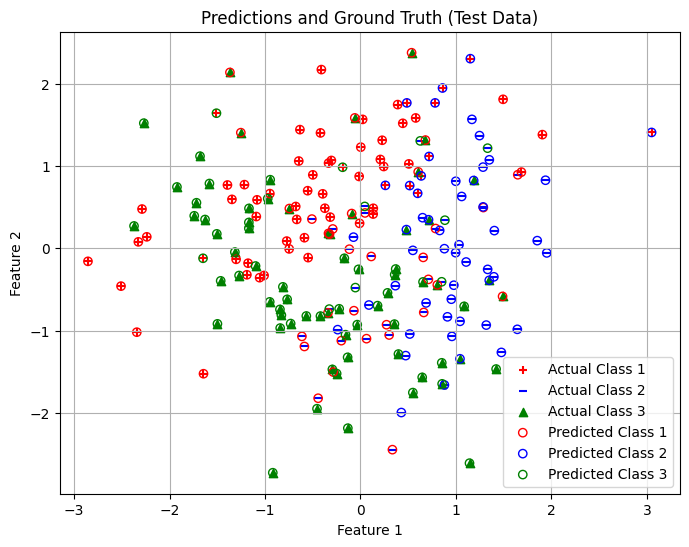

In [ ]:
import matplotlib.pyplot as plt

# Define colors and markers for visualization
colors = ['red', 'blue', 'green']
markers = ['+', '_', '^']  # Updated markers for actual classes

# Create a scatter plot for actual vs predicted classes
plt.figure(figsize=(8, 6))

# Plot actual classes
for class_idx in range(3):  # Assuming 3 classes
    test_points = X_test[y_test_true == class_idx]
    plt.scatter(
        test_points[:, 0], test_points[:, 1],
        marker=markers[class_idx],
        color=colors[class_idx],
        label=f'Actual Class {class_idx + 1}'
    )

# Plot predicted classes
predicted_points = nn.predict(X_test)  # Predicted class labels
for class_idx in range(3):  # Assuming 3 classes
    pred_points = X_test[predicted_points == class_idx]
    plt.scatter(
        pred_points[:, 0], pred_points[:, 1],
        facecolors='none', edgecolors=colors[class_idx],
        label=f'Predicted Class {class_idx + 1}'
    )

# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Testing
pred_test = NN.feedForward(X_test)
pred_labels = np.argmax(pred_test, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print("Accuracy:", accuracy)

# Calculate other performance metrics
print("Classification Report:")
print(classification_report(true_labels, pred_labels))




In [ ]:
Accuracy: 0.215
Classification Report:
              precision    recall  f1-score   support

           0       0.21      1.00      0.35        43
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        38
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        47

    accuracy                           0.21       200
   macro avg       0.04      0.20      0.07       200
weighted avg       0.05      0.21      0.08       200

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))